## **Adversarial Perturbations Fool Deepfake Detectors**
FIT3183 2020 S2 Assignment
<br/>By Team Dark.HAIYA
<br/>Team members:
- Kee Pei Jiin
- Chin Wen Yuan

This colab demonstrates our attempts to fool an XceptionNet deepfake detector. It is created based on this [research paper](https://arxiv.org/pdf/2003.10596.pdf)[1] and its corresponding [GitHub](https://github.com/ApGa/adversarial_deepfakes).

You can watch our demo video at:

## **Colab Setup**
Please change runtime type to GPU.

### **Import Libraries**

In [2]:
import sys 
import os
import glob
import imghdr
import numpy as np
from math import ceil
from PIL import Image
import keras.utils as image
from keras.applications.xception import preprocess_input
from keras.models import load_model
from keras.losses import categorical_crossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

### **Helper Functions**
Some functions that help to process images, evaluate model performance and display outputs.

In [3]:
# for data/image preparation
classes = ["real", "fake"] # label 0: real, label 1: fake
num_classes = 2
IMG_SIZE = 1024

def load_images_and_prepare_labels(image_folder_path):
    images_paths, labels = [], []
    for class_name in os.listdir(image_folder_path):
      class_root = os.path.join(image_folder_path, class_name)
      class_id = classes.index(class_name)
      for path in os.listdir(class_root):
          path = os.path.join(class_root, path)
          if imghdr.what(path) is None:
              # this is not an image file
              continue
          images_paths.append(path)
          labels.append(class_id)
    # convert ot numpy array
    images_paths = np.array(images_paths)
    return images_paths, labels

In [4]:
# for model classification
def load_image_as_np_arr(img_path): # load img as np array
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x);
    return x

def load_image_as_tensor(img_path): # load img as tensor
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img)
    img = img[None, ...]
    return img

data_to_save_fake = []
data_to_save_real = []
data_to_save_all = []

def classify(model, x, nameModel="", fake=False, real=False, filename=""): # x is a np array, use model to predict the label of x
    with open(os.devnull, 'w') as devnull:
        # Сохраняем стандартный поток вывода
        old_stdout = sys.stdout
        # Перенаправляем стандартный поток вывода в никуда
        sys.stdout = devnull
        pred = model.predict(x)[0];
        sys.stdout = old_stdout
        pred_label = np.argmax(pred)
        if fake == False and real == False:
            data_to_save_all.append(str(filename)+f" label_class = {pred_label} " + str(pred[0]) + str(pred[1]))
        
        if fake == True:
            data_to_save_fake.append(str(filename)+f" label_class = {pred_label}   "+ str(pred[0]) + " " + str(pred[1]))

        if real == True:
            data_to_save_real.append(str(filename)+f" label_class = {pred_label}   ", str(pred[0]) + " " + str(pred[1]))

        return pred_label

In [5]:
# for image visualization
def denormalize_img(x):
    # x is the image represented in numpy array
    x = (x+1)*127.5
    x /= 255
    # x = np.clip(x, 0, 255)
    return x

# visualize normal & perturbed image side by side
# also display their prediction labels
def display_image_pair(x, adv_x, actual_label, pred_label):
    # x and adv_x are numpy arrays
    x = x.squeeze()
    x = denormalize_img(x)
    adv_x = adv_x.squeeze()
    adv_x = denormalize_img(adv_x)

    # both x and adv_x are numpy array
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(x); ax[0].axis("off")
    ax[0].set_title("Original image", fontsize=15)
    ax[0].text(0.5,-0.13, "Actual class: {}".format(classes[actual_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[1].imshow(adv_x); ax[1].axis("off")
    ax[1].set_title("Perturbed image", fontsize=15)
    ax[1].text(1.8,-0.13, "Predicted class: {}".format(classes[pred_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[2].axis("off")
    
    plt.show()

## **Datasets**
Initially, we attempted to generate our own deepfake images following the [Pytorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). Our [Kaggle notebook](https://www.kaggle.com/peijiin/synthesize-face-images-with-dcgan) generates 500 fake images with the dimension of 128*128 using the CelebA dataset.

However, we found the quality of our deepfakes is too low, and the quality does not improve even after we increase the epoch number. Hence, we decided to use a set of 1000 DCGAN fake images generated by [2]. Interestingly, this research work is also the main reference paper of Team Light.DP. The researchers had also trained a DCGAN to generate fake images using the CelebA dataset. When compared to our fake images, the researchers' fake images generally have higher quality, as shown below.



As such, the images we use in this assignment are as follows:
- Real images: 1000 cropped celebA images, with size of 128*128. 

- Fake images: 1000 DGCAN fake images generated by [2], with size 128*128.

More of our dataset preparation can be found in [this Colab](https://colab.research.google.com/drive/1cqEkS3ZE2gcMsxBqHBv1epfdkgzfY695?usp=sharing).

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from tqdm import tqdm

def evaluate_model_performance(img_paths, labels, color, attack_fn=None, display_num=3, nameModel="", fake=False, real=False, rocLabel = ""):
    # positive: fake, negative: real
    true_positive = 0   # predict fake as fake
    false_positive = 0  # predict fake as real
    true_negative = 0   # predict real as real
    false_negative = 0  # predict real as fake
    predictions = []  # Список для хранения предсказанных классов
    for i in tqdm(range(len(img_paths))):
      img_path = img_paths[i]
      actual_label = labels[i]
      #print(img_path)
      # load an input image
      x = load_image_as_np_arr(img_path);

      # predict the label of image

      pred_label = classify(final_model, x, nameModel=nameModel, fake=fake, real=real, filename=img_path);
      predictions.append(pred_label)


      if actual_label == 0:
        if pred_label == 0:
          true_negative += 1
        else:
          false_negative += 1
      else:
        if pred_label == 1:
          true_positive += 1
        else:
          false_positive += 1
    
    print("Predict fake as fake: %d" %true_positive)
    print("Predict fake as real: %d" %false_positive)
    print("Predict real as real: %d" %true_negative)
    print("Predict real as fake: %d" %false_negative)
    
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    print(f'ROC_AUC: {roc_auc}')        
    # Построение ROC кривой
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve {rocLabel} (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=color, lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    #plt.show()
    
    print(classification_report(labels, predictions))
    
    if fake == True:
      np.savetxt(f'predict_fake_images_{nameModel}.txt', data_to_save_fake, fmt='%s')
    if real == True:
      np.savetxt(f'predict_real_images_{nameModel}.txt', data_to_save_real, fmt='%s')
    if fake == False and real == False:
      np.savetxt(f'predict_all_images_{nameModel}.txt', data_to_save_all, fmt='%s')
    return true_positive, false_positive, true_negative, false_negative

In [16]:
# baseModelPath = "D:\\DeepFakeRepos\\AllModels\\DeepFakeDetectionModels\\XceptionNet\\model_fine_final.h5"
# roopModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Xception_100\\model_ROOP_100_5_Final.h5'
# ghostModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Xception_100\\model_GHOST_Final_100_20ep.h5'
# olderModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Xception_100\\model_E4E_Older_2_1_pop_Final_100_20ep.h5'
# smileModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Xception_100\\model_E4E_Smile_Final_100_1.h5'

# # Все выборки по 100
# roopDataPath = "D:\\DeepFakeRepos\\Datasets\\RoopData"
# ghostDataPath = "D:\\DeepFakeRepos\\Datasets\\GhostData"
# olderDataPath = "D:\\DeepFakeRepos\\Datasets\\OlderData"
# smileDataPath = "D:\\DeepFakeRepos\\Datasets\\SmileData"
# faceForensicsPath = "D:\\DeepFakeRepos\\Datasets\\FaceForensics"

# Модели на 1000
baseModelPath = "D:\\DeepFakeRepos\\AllModels\\DeepFakeDetectionModels\\XceptionNet\\model_fine_final.h5"
roopModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Xception1000\\model_fine_ROOP_1000_1_Final.h5'
ghostModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Xception1000\\model_fine_GHOST_1000_1_Final.h5'
olderModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Xception1000\\model_fine_Older_1000_1_Final.h5'
smileModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Xception1000\\model_fine_Smile_1000_1_Final.h5'

# Все выборки по 100 (не участыующие в обучении даже косвенно)
roopDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\RoopData"
ghostDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\GhostData"
olderDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\OlderData"
smileDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\SmileData"
faceForensicsPath = "D:\\DeepFakeRepos\\DatasetsUnique\\FaceForensics"
baseDataTestPath = "D:\\DeepFakeRepos\\AllModels\\DeepFakeDetectionModels\\XceptionNet\\testing_images"

Model name BASE
BASE DATA


100%|██████████| 400/400 [00:31<00:00, 12.63it/s]


Predict fake as fake: 185
Predict fake as real: 15
Predict real as real: 199
Predict real as fake: 1
ROC_AUC: 0.9600000000000001
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.99      0.93      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400

Predict fake as fake: 185
Predict fake as real: 15
Predict real as real: 199
Predict real as fake: 1

ROOP DATA


100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


Predict fake as fake: 48
Predict fake as real: 52
Predict real as real: 57
Predict real as fake: 43
ROC_AUC: 0.525
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       100
           1       0.53      0.48      0.50       100

    accuracy                           0.53       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.53      0.53      0.52       200

Predict fake as fake: 48
Predict fake as real: 52
Predict real as real: 57
Predict real as fake: 43

GHOST DATA


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Predict fake as fake: 40
Predict fake as real: 60
Predict real as real: 52
Predict real as fake: 48
ROC_AUC: 0.45999999999999996
              precision    recall  f1-score   support

           0       0.46      0.52      0.49       100
           1       0.45      0.40      0.43       100

    accuracy                           0.46       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.46      0.46       200

Predict fake as fake: 40
Predict fake as real: 60
Predict real as real: 52
Predict real as fake: 48

OLDER DATA


100%|██████████| 200/200 [02:44<00:00,  1.21it/s]


Predict fake as fake: 63
Predict fake as real: 37
Predict real as real: 53
Predict real as fake: 47
ROC_AUC: 0.58
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       100
           1       0.57      0.63      0.60       100

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58       200

Predict fake as fake: 63
Predict fake as real: 37
Predict real as real: 53
Predict real as fake: 47

SMILE DATA


100%|██████████| 200/200 [02:40<00:00,  1.25it/s]


Predict fake as fake: 64
Predict fake as real: 36
Predict real as real: 48
Predict real as fake: 52
ROC_AUC: 0.56
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       100
           1       0.55      0.64      0.59       100

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

Predict fake as fake: 64
Predict fake as real: 36
Predict real as real: 48
Predict real as fake: 52

FACEFORENSICS DATA


100%|██████████| 195/195 [02:37<00:00,  1.24it/s]

Predict fake as fake: 57
Predict fake as real: 43
Predict real as real: 50
Predict real as fake: 45
ROC_AUC: 0.5481578947368421
              precision    recall  f1-score   support

           0       0.54      0.53      0.53        95
           1       0.56      0.57      0.56       100

    accuracy                           0.55       195
   macro avg       0.55      0.55      0.55       195
weighted avg       0.55      0.55      0.55       195

Predict fake as fake: 57
Predict fake as real: 43
Predict real as real: 50
Predict real as fake: 45



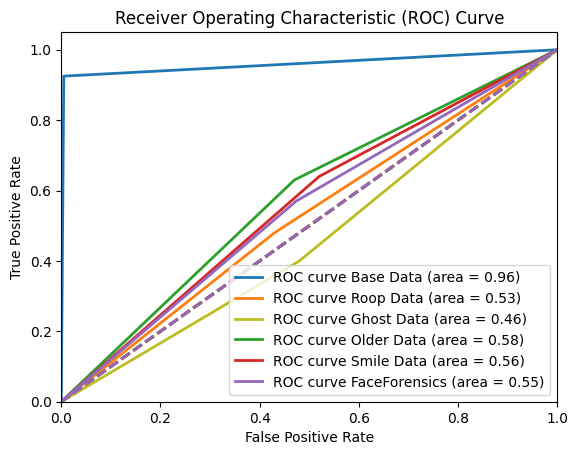

In [17]:
final_model = load_model(baseModelPath)
nameModel = "BASE"
colors = plt.cm.tab10(np.linspace(0, 1, 10))
IMG_SIZE = 128
print(f"Model name {nameModel}")
plt.figure()
print("BASE DATA")
all_images, labels = load_images_and_prepare_labels(baseDataTestPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[0], nameModel=nameModel, rocLabel="Base Data");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

IMG_SIZE = 1024
print("ROOP DATA")
all_images, labels = load_images_and_prepare_labels(roopDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[1], nameModel=nameModel, rocLabel="Roop Data");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[8], nameModel=nameModel, rocLabel="Ghost Data");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("OLDER DATA")
all_images, labels = load_images_and_prepare_labels(olderDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[2], nameModel=nameModel, rocLabel="Older Data");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("SMILE DATA")
all_images, labels = load_images_and_prepare_labels(smileDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[3], nameModel=nameModel, rocLabel="Smile Data");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("FACEFORENSICS DATA")
all_images, labels = load_images_and_prepare_labels(faceForensicsPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, color=colors[4], nameModel=nameModel, rocLabel="FaceForensics");
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()
plt.show()

Model name ROOP
BASE DATA


100%|██████████| 400/400 [05:19<00:00,  1.25it/s]

ROC_AUC: 0.5399999999999999


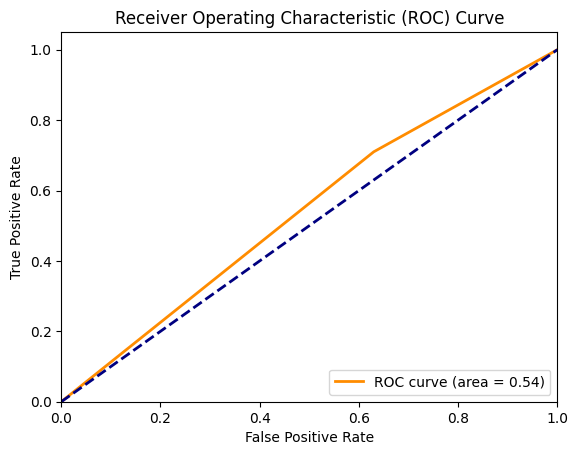

              precision    recall  f1-score   support

           0       0.56      0.37      0.45       200
           1       0.53      0.71      0.61       200

    accuracy                           0.54       400
   macro avg       0.55      0.54      0.53       400
weighted avg       0.55      0.54      0.53       400

Predict fake as fake: 142
Predict fake as real: 58
Predict real as real: 74
Predict real as fake: 126

ROOP DATA


100%|██████████| 200/200 [02:59<00:00,  1.11it/s]

ROC_AUC: 1.0


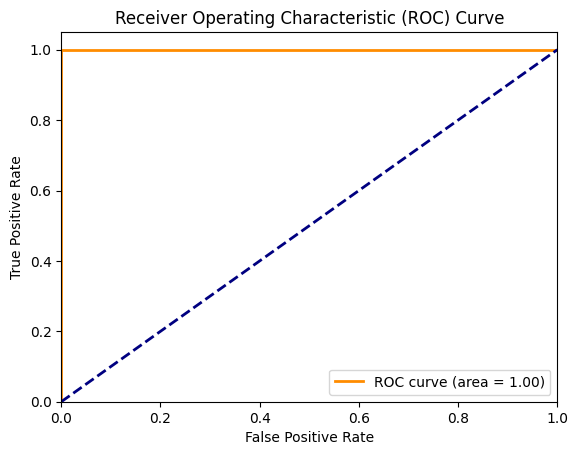

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 100
Predict real as fake: 0

GHOST DATA


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]

ROC_AUC: 0.535


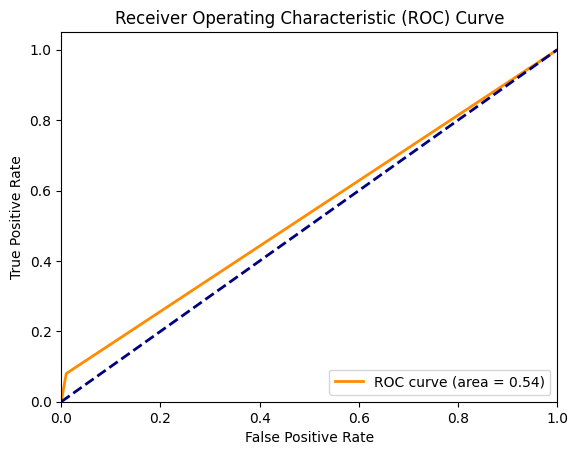

              precision    recall  f1-score   support

           0       0.52      0.99      0.68       100
           1       0.89      0.08      0.15       100

    accuracy                           0.54       200
   macro avg       0.70      0.54      0.41       200
weighted avg       0.70      0.54      0.41       200

Predict fake as fake: 8
Predict fake as real: 92
Predict real as real: 99
Predict real as fake: 1

OLDER DATA


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]

ROC_AUC: 0.495


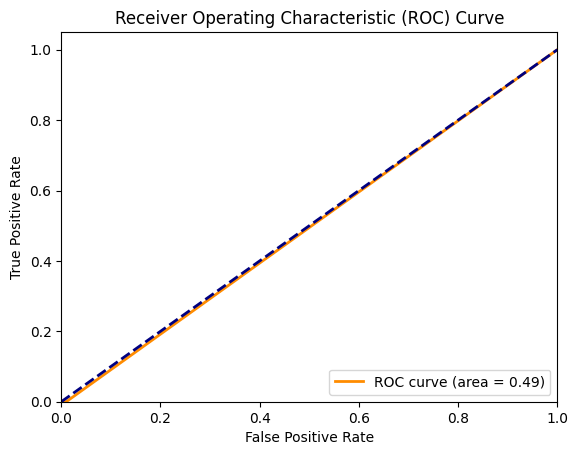

              precision    recall  f1-score   support

           0       0.50      0.99      0.66       100
           1       0.00      0.00      0.00       100

    accuracy                           0.49       200
   macro avg       0.25      0.49      0.33       200
weighted avg       0.25      0.49      0.33       200

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 99
Predict real as fake: 1

SMILE DATA


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]

ROC_AUC: 0.5


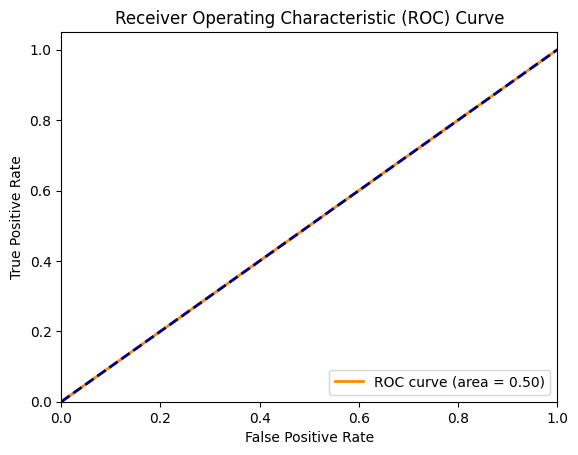

c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 100
Predict real as fake: 0

FACEFORENSIKS DATA


100%|██████████| 195/195 [02:38<00:00,  1.23it/s]

ROC_AUC: 0.8663157894736842


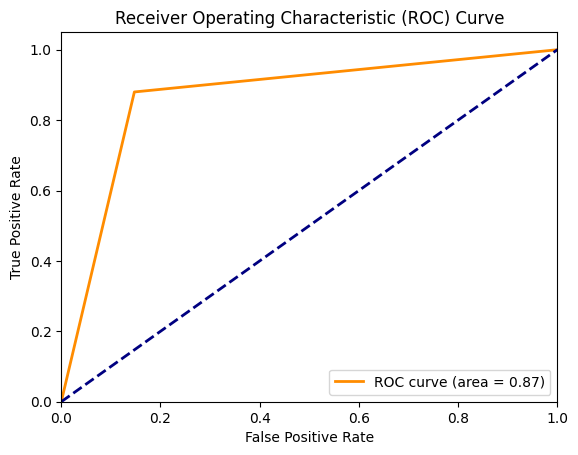

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        95
           1       0.86      0.88      0.87       100

    accuracy                           0.87       195
   macro avg       0.87      0.87      0.87       195
weighted avg       0.87      0.87      0.87       195

Predict fake as fake: 88
Predict fake as real: 12
Predict real as real: 81
Predict real as fake: 14



In [11]:
IMG_SIZE = 1024
final_model = load_model(roopModelPath)
nameModel = "ROOP"

print(f"Model name {nameModel}")

print("BASE DATA")
all_images, labels = load_images_and_prepare_labels(baseDataTestPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("ROOP DATA")
all_images, labels = load_images_and_prepare_labels(roopDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("OLDER DATA")
all_images, labels = load_images_and_prepare_labels(olderDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("SMILE DATA")
all_images, labels = load_images_and_prepare_labels(smileDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("FACEFORENSIKS DATA")
all_images, labels = load_images_and_prepare_labels(faceForensicsPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()
# ROOP_DATA

Model name GHOST
BASE DATA


100%|██████████| 400/400 [04:43<00:00,  1.41it/s]

ROC_AUC: 0.5


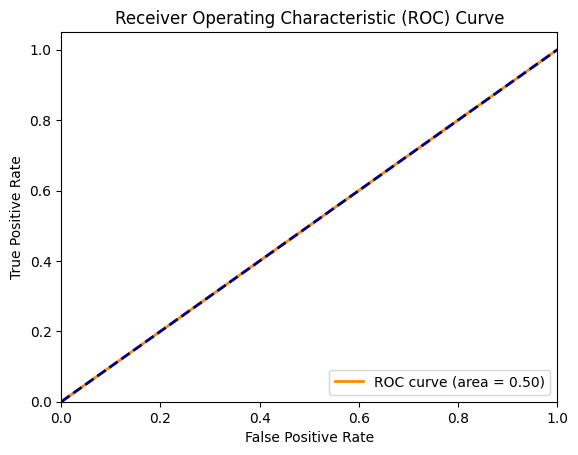

c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400

Predict fake as fake: 200
Predict fake as real: 0
Predict real as real: 0
Predict real as fake: 200

ROOP DATA


100%|██████████| 200/200 [02:30<00:00,  1.33it/s]

ROC_AUC: 0.9


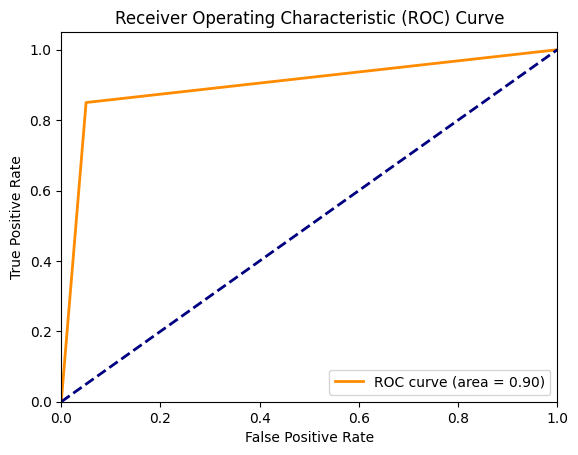

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       100
           1       0.94      0.85      0.89       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Predict fake as fake: 85
Predict fake as real: 15
Predict real as real: 95
Predict real as fake: 5

GHOST DATA


100%|██████████| 200/200 [02:32<00:00,  1.31it/s]

ROC_AUC: 0.985


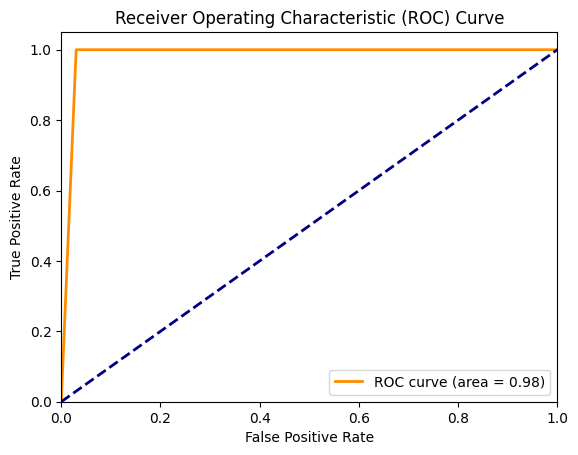

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       0.97      1.00      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 97
Predict real as fake: 3

OLDER DATA


100%|██████████| 200/200 [02:37<00:00,  1.27it/s]

ROC_AUC: 0.515


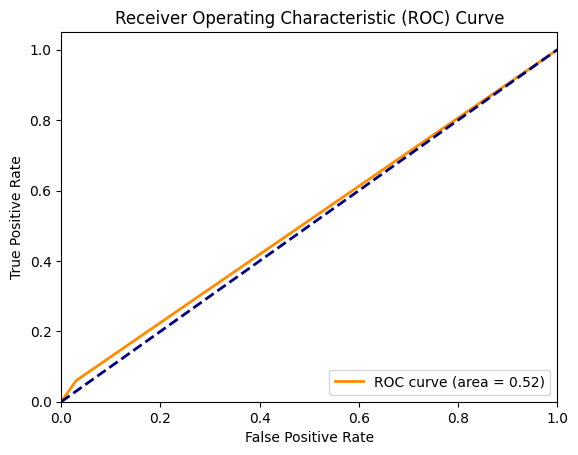

              precision    recall  f1-score   support

           0       0.51      0.97      0.67       100
           1       0.67      0.06      0.11       100

    accuracy                           0.52       200
   macro avg       0.59      0.52      0.39       200
weighted avg       0.59      0.52      0.39       200

Predict fake as fake: 6
Predict fake as real: 94
Predict real as real: 97
Predict real as fake: 3

SMILE DATA


100%|██████████| 200/200 [02:31<00:00,  1.32it/s]

ROC_AUC: 0.505


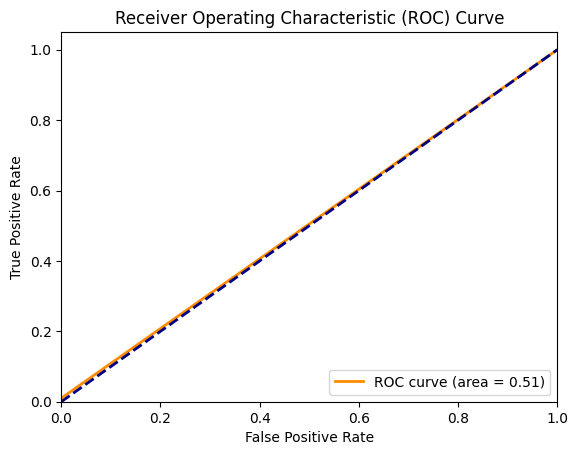

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.01      0.02       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200

Predict fake as fake: 1
Predict fake as real: 99
Predict real as real: 100
Predict real as fake: 0

FACEFORENSIKS DATA


100%|██████████| 195/195 [02:26<00:00,  1.33it/s]

ROC_AUC: 0.6894736842105262


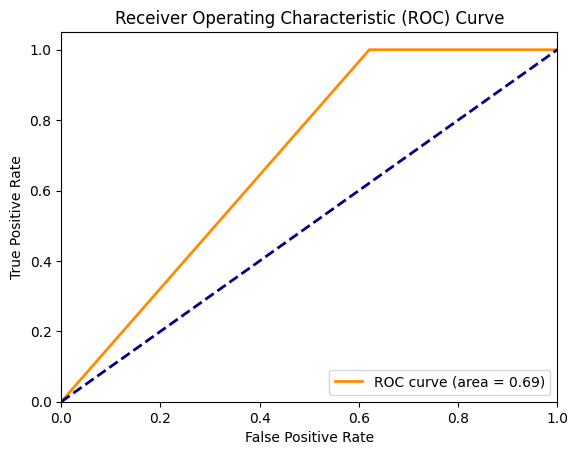

              precision    recall  f1-score   support

           0       1.00      0.38      0.55        95
           1       0.63      1.00      0.77       100

    accuracy                           0.70       195
   macro avg       0.81      0.69      0.66       195
weighted avg       0.81      0.70      0.66       195

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 36
Predict real as fake: 59



In [12]:
IMG_SIZE = 1024
final_model = load_model(ghostModelPath)
nameModel = "GHOST"

print(f"Model name {nameModel}")

print("BASE DATA")
all_images, labels = load_images_and_prepare_labels(baseDataTestPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("ROOP DATA")
all_images, labels = load_images_and_prepare_labels(roopDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("OLDER DATA")
all_images, labels = load_images_and_prepare_labels(olderDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("SMILE DATA")
all_images, labels = load_images_and_prepare_labels(smileDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("FACEFORENSIKS DATA")
all_images, labels = load_images_and_prepare_labels(faceForensicsPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()
# GHOST_DATA
#label 0: real, label 1: fake

Model name OLDER
BASE DATA


100%|██████████| 400/400 [04:47<00:00,  1.39it/s]

ROC_AUC: 0.4825


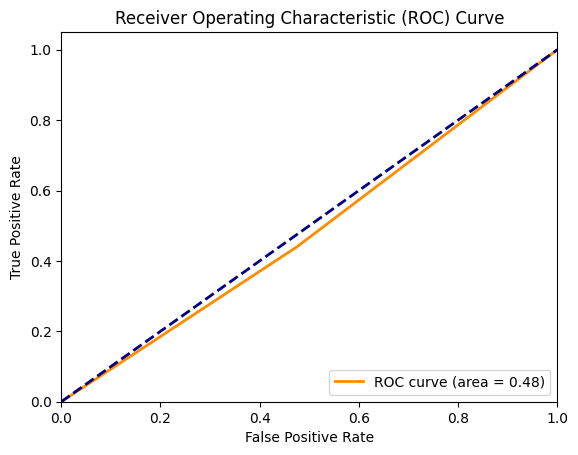

              precision    recall  f1-score   support

           0       0.48      0.53      0.50       200
           1       0.48      0.44      0.46       200

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.48      0.48       400

Predict fake as fake: 88
Predict fake as real: 112
Predict real as real: 105
Predict real as fake: 95

ROOP DATA


100%|██████████| 200/200 [04:12<00:00,  1.26s/it]

ROC_AUC: 0.5


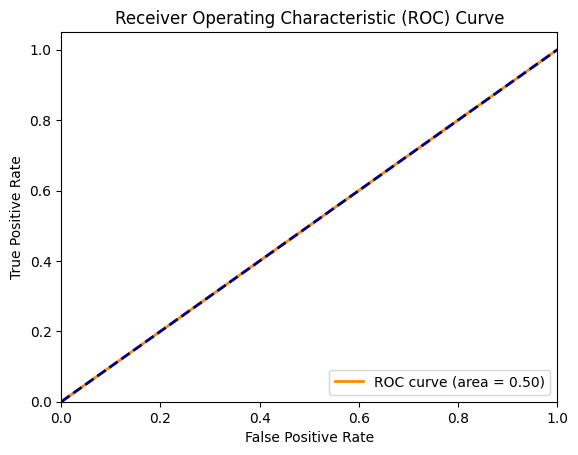

c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 100
Predict real as fake: 0

GHOST DATA


100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


ROC_AUC: 0.515


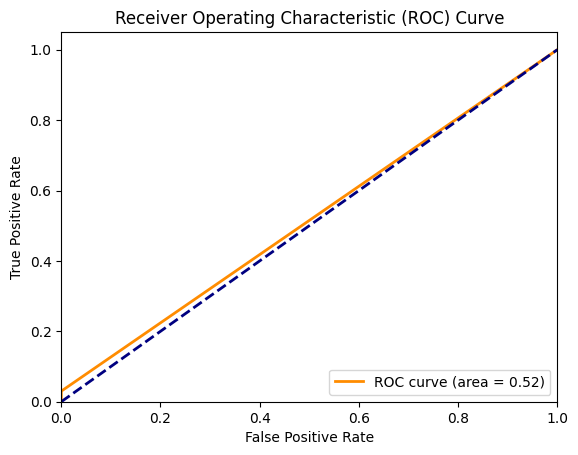

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       100
           1       1.00      0.03      0.06       100

    accuracy                           0.52       200
   macro avg       0.75      0.52      0.37       200
weighted avg       0.75      0.52      0.37       200

Predict fake as fake: 3
Predict fake as real: 97
Predict real as real: 100
Predict real as fake: 0

OLDER DATA


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]

ROC_AUC: 0.995


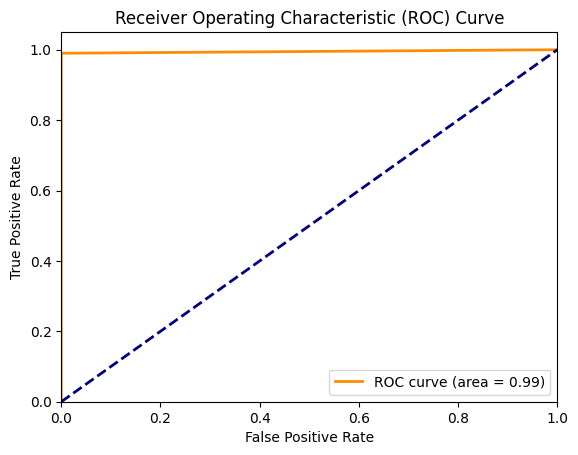

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

Predict fake as fake: 99
Predict fake as real: 1
Predict real as real: 100
Predict real as fake: 0

SMILE DATA


100%|██████████| 200/200 [04:02<00:00,  1.21s/it]

ROC_AUC: 0.685


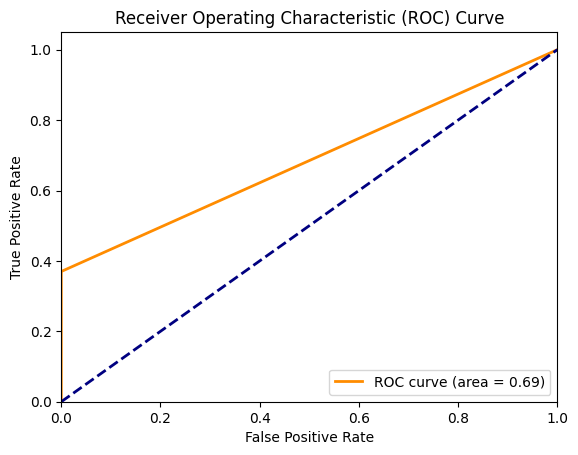

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       100
           1       1.00      0.37      0.54       100

    accuracy                           0.69       200
   macro avg       0.81      0.69      0.65       200
weighted avg       0.81      0.69      0.65       200

Predict fake as fake: 37
Predict fake as real: 63
Predict real as real: 100
Predict real as fake: 0

FACEFORENSICS DATA


100%|██████████| 195/195 [02:34<00:00,  1.26it/s]

ROC_AUC: 0.45789473684210524


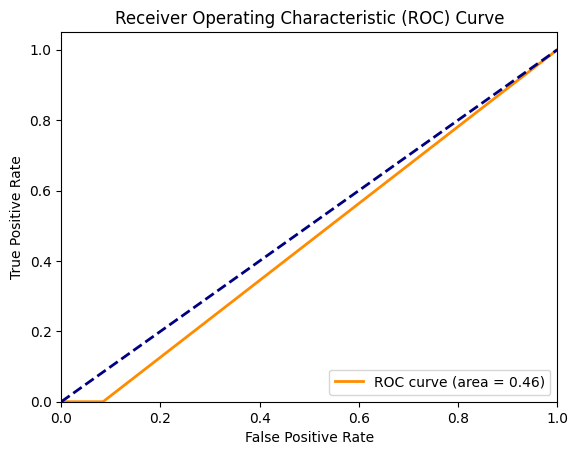

              precision    recall  f1-score   support

           0       0.47      0.92      0.62        95
           1       0.00      0.00      0.00       100

    accuracy                           0.45       195
   macro avg       0.23      0.46      0.31       195
weighted avg       0.23      0.45      0.30       195

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 87
Predict real as fake: 8



In [9]:
IMG_SIZE = 1024
final_model = load_model(olderModelPath)
nameModel = "OLDER"

print(f"Model name {nameModel}")

print("BASE DATA")
all_images, labels = load_images_and_prepare_labels(baseDataTestPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("ROOP DATA")
all_images, labels = load_images_and_prepare_labels(roopDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("OLDER DATA")
all_images, labels = load_images_and_prepare_labels(olderDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("SMILE DATA")
all_images, labels = load_images_and_prepare_labels(smileDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("FACEFORENSICS DATA")
all_images, labels = load_images_and_prepare_labels(faceForensicsPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()
# OLDER_DATA

Model name SMILE
BASE DATA


100%|██████████| 400/400 [04:39<00:00,  1.43it/s]

ROC_AUC: 0.5


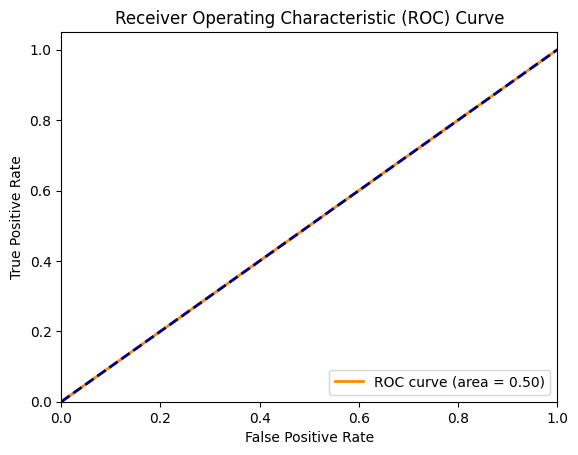

c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       200
           1       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400

Predict fake as fake: 0
Predict fake as real: 200
Predict real as real: 200
Predict real as fake: 0

ROOP DATA


100%|██████████| 200/200 [02:26<00:00,  1.37it/s]

ROC_AUC: 0.505


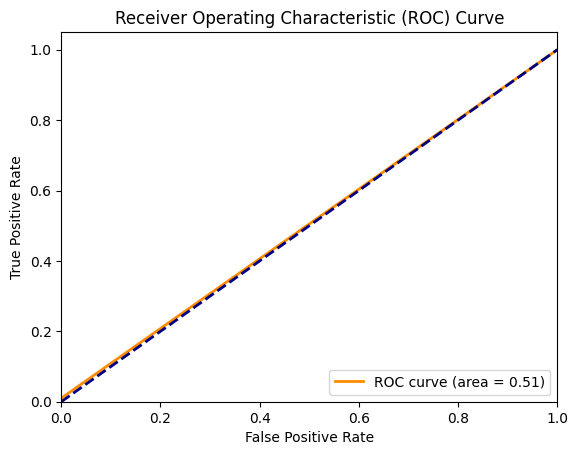

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       1.00      0.01      0.02       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200

Predict fake as fake: 1
Predict fake as real: 99
Predict real as real: 100
Predict real as fake: 0

GHOST DATA


100%|██████████| 200/200 [02:23<00:00,  1.39it/s]

ROC_AUC: 0.5


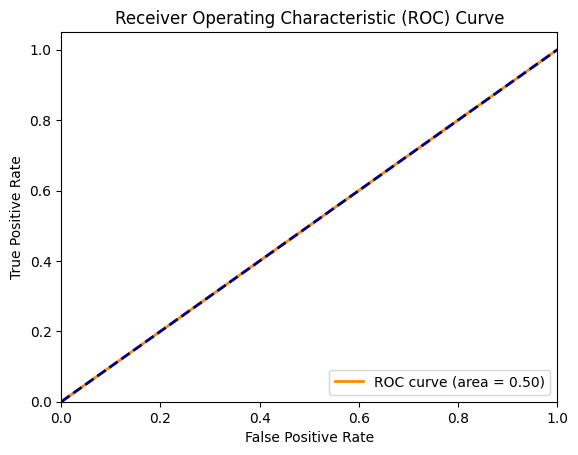

c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Apps\envs\Xception\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 100
Predict real as fake: 0

OLDER DATA


100%|██████████| 200/200 [02:24<00:00,  1.39it/s]

ROC_AUC: 1.0


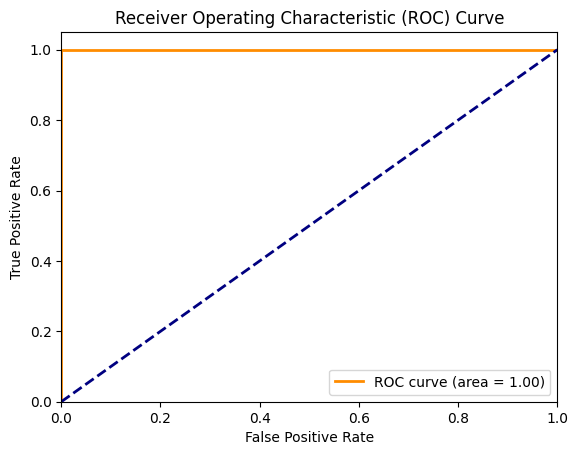

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 100
Predict real as fake: 0

SMILE DATA


100%|██████████| 200/200 [02:28<00:00,  1.35it/s]

ROC_AUC: 1.0


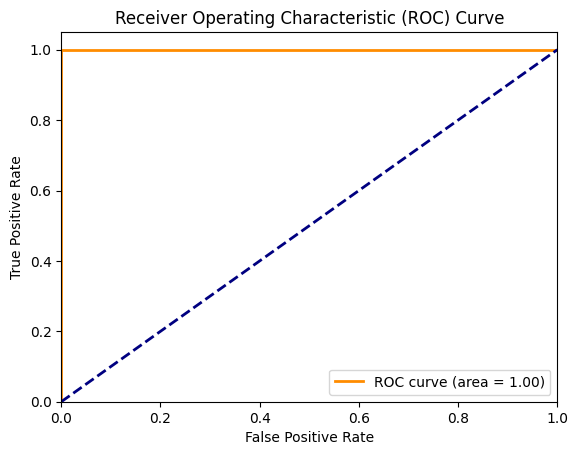

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 100
Predict real as fake: 0

FACEFORENSICS DATA


100%|██████████| 195/195 [02:18<00:00,  1.41it/s]


ROC_AUC: 0.42105263157894735


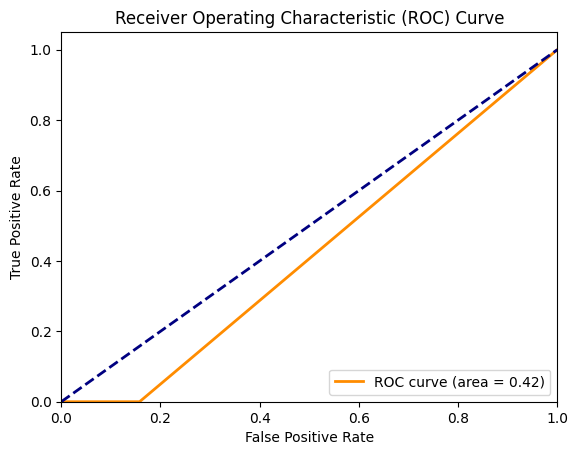

              precision    recall  f1-score   support

           0       0.44      0.84      0.58        95
           1       0.00      0.00      0.00       100

    accuracy                           0.41       195
   macro avg       0.22      0.42      0.29       195
weighted avg       0.22      0.41      0.28       195

Predict fake as fake: 0
Predict fake as real: 100
Predict real as real: 80
Predict real as fake: 15



In [13]:
IMG_SIZE = 1024
final_model = load_model(smileModelPath)
nameModel = "SMILE"

print(f"Model name {nameModel}")

print("BASE DATA")
all_images, labels = load_images_and_prepare_labels(baseDataTestPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("ROOP DATA")
all_images, labels = load_images_and_prepare_labels(roopDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("OLDER DATA")
all_images, labels = load_images_and_prepare_labels(olderDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("SMILE DATA")
all_images, labels = load_images_and_prepare_labels(smileDataPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

print("FACEFORENSICS DATA")
all_images, labels = load_images_and_prepare_labels(faceForensicsPath);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()
# SMILE_DATA

Model name GHOST
GHOST DATA


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 98
Predict real as fake: 2
ROC_AUC: 0.99


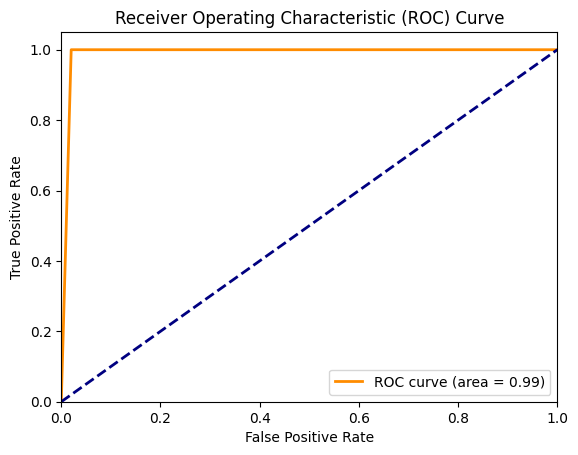

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Predict fake as fake: 100
Predict fake as real: 0
Predict real as real: 98
Predict real as fake: 2



In [19]:

def load_images_and_prepare_labels_one(image_folder_path):
    images_paths, labels = [], []
    for path in os.listdir(image_folder_path):
        class_id = classes.index("real")
        path = os.path.join(image_folder_path, path)
        if imghdr.what(path) is None:
            # this is not an image file
            continue
        images_paths.append(path)
        labels.append(class_id)
    # convert ot numpy array
    images_paths = np.array(images_paths)
    return images_paths, labels

classes = ["real", "fake"]
ghostDataPathTest = "D:\\DeepFakeRepos\\DatasetsCompressed"
final_model = load_model(ghostModelPath)
nameModel = "GHOST"

print(f"Model name {nameModel}")

print("GHOST DATA")
all_images, labels = load_images_and_prepare_labels(ghostDataPathTest);
tp, fp, tn, fn = evaluate_model_performance(img_paths=all_images, labels=labels, nameModel=nameModel);
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)
print()

In [1]:
from sklearn.metrics import confusion_matrix
y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]
print(confusion_matrix(y_true, y_pred))

[[2 0]
 [1 3]]
